In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from tableone import TableOne

%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
mimic_lr = pd.read_csv("GeneratedFiles/Databases/mimic_lr.csv", sep=';', encoding='ISO-8859-1')
mimic_rf = pd.read_csv("GeneratedFiles/Databases/mimic_rf.csv", sep=';', encoding='ISO-8859-1')
mimic_pls = pd.read_csv("GeneratedFiles/Databases/mimic_pls.csv", sep=';', encoding='ISO-8859-1')

* Cargo solo las variables seleccionadas como importantes

In [3]:
lr_important=pd.read_csv("GeneratedFiles/ImportantVariables/lr_important.csv", sep=',', encoding='ISO-8859-1')
list_lr_important=list(lr_important['colummn'].values)
list_lr_important.append('lactate_label')

rf_important=pd.read_csv("GeneratedFiles/ImportantVariables/rf_important.csv", sep=',', encoding='ISO-8859-1')
list_rf_important=list(rf_important['colummn'].values)
list_rf_important.append('lactate_label')

pls_important=pd.read_csv("GeneratedFiles/ImportantVariables/pls_important.csv", sep=',', encoding='ISO-8859-1')
list_pls_important=list(pls_important['colummn'].values)
list_pls_important.append('lactate_label')

In [4]:
mimic_lr = mimic_lr[list_lr_important]

mimic_rf = mimic_rf[list_rf_important]

mimic_pls = mimic_pls[list_pls_important]

# Logistic Regression with CV
***

- MIMIC

In [5]:
print("--------------------------")

print("Logistic Regression at MIMIC with features selected")

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


--------------------------
Logistic Regression at MIMIC with features selected


In [6]:
from sklearn.model_selection import cross_validate


mimic_lr_2 = mimic_lr.copy()
categorical=mimic_lr[list(mimic_lr.columns[mimic_lr.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    mimic_lr[col] = np.where(mimic_lr[col]=='Yes',1,0)

mimic_lr['lactate_label'] = np.where(mimic_lr['lactate_label'] == 'high',1,0)

lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
y_lr = mimic_lr['lactate_label']
x_lr= mimic_lr.drop(['lactate_label'],axis=1)

cv_model = cross_validate(lr, x_lr, y_lr, cv=5, return_train_score=True, return_estimator=True, scoring = ['accuracy', 'recall', 'roc_auc'])
scores=pd.DataFrame(cv_model['test_accuracy'])
scores.columns=['score']
scores = scores.sort_values('score',ascending=False)
print("Scores of Cross Validation")
print(scores)

best_estimator = cv_model['estimator'][scores.iloc[0].name]

print('roc '+str(cv_model['test_roc_auc'][scores.iloc[0].name]))
print('recall '+str(cv_model['test_recall'][scores.iloc[0].name]))

Scores of Cross Validation
      score
2  0.803089
3  0.802326
4  0.782946
0  0.753846
1  0.742308
roc 0.8740878169449599
recall 0.8701298701298701


Importance of features for MIMIC after CV


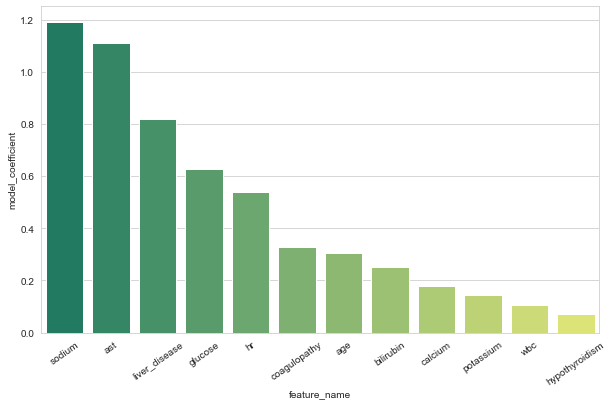

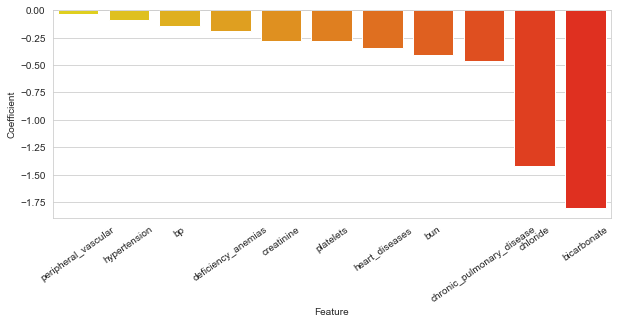

In [7]:
print("Importance of features for MIMIC after CV") 
# Get the models coefficients (and top 5 and bottom 5)
logReg_coeff_lr_mimic = pd.DataFrame({'feature_name': x_lr.columns.values, 'model_coefficient': best_estimator.coef_.transpose().flatten()})
logReg_coeff_lr_mimic = logReg_coeff_lr_mimic.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff_lr_mimic.head(sum(logReg_coeff_lr_mimic['model_coefficient']>0))
logReg_coeff_bottom = logReg_coeff_lr_mimic.tail(sum(logReg_coeff_lr_mimic['model_coefficient']<0))


# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="summer")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure().set_size_inches(10,6)
fg4 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="autumn_r")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
# plt.savefig('figure_4.png')

In [8]:
print("Classification")

from sklearn import metrics
pred=best_estimator.predict(x_lr)
classes_lr=np.where(np.logical_and(pred==1,y_lr.values==1),'TP',
         np.where(np.logical_and(pred==1,y_lr.values==0),'FP',
                  np.where(np.logical_and(pred==0,y_lr.values==0), 'TN',
                           np.where(np.logical_and(pred==0,y_lr.values==1),'FN','MAL'))))
import scipy
print(scipy.stats.itemfreq(classes_lr))


Classification
[['FN' '129']
 ['FP' '151']
 ['TN' '376']
 ['TP' '639']]


In [9]:
logReg_coeff_lr_mimic.to_csv('GeneratedFiles/ImportantVariables/coef_lr_mimic_2.csv', sep=';', header = False, index=False)

# RandomForest with CV
***

- MIMIC

In [10]:
print("--------------------------")

print("Random Forest at MIMIC for feature selection")


--------------------------
Random Forest at MIMIC for feature selection


Score for CV
      score
3  0.802326
1  0.773077
2  0.760618
4  0.751938
0  0.734615
roc 0.8710862122626828
recall 0.8954248366013072


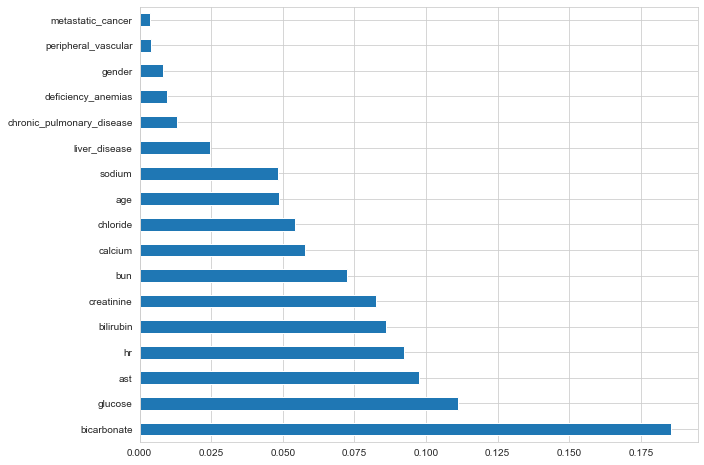

In [11]:
from sklearn.model_selection import cross_validate
mimic_rf_2 = mimic_rf.copy()

mimic_rf_3 = mimic_rf_2.copy()

mimic_rf_2['gender'] = np.where(mimic_rf_2['gender']=='M',1,0)

categorical=mimic_rf_2[list(mimic_rf_2.columns[mimic_rf_2.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    mimic_rf_2[col] = np.where(mimic_rf_2[col]=='Yes',1,0)

mimic_rf_2['lactate_label'] = np.where(mimic_rf_2['lactate_label'] == 'high',1,0)

rf = RandomForestClassifier(n_estimators=200, random_state=0,max_depth=10, n_jobs=-1)
y_rf = mimic_rf_2['lactate_label']
x_rf= mimic_rf_2.drop(['lactate_label'],axis=1)


cv_model = cross_validate(rf, x_rf, y_rf, cv=5, return_train_score=True, return_estimator=True, scoring = ['accuracy', 'recall', 'roc_auc'])
scores=pd.DataFrame(cv_model['test_accuracy'])
scores.columns=['score']
scores = scores.sort_values('score',ascending=False)
print("Score for CV")
print(scores)

bestRF = cv_model['estimator'][scores.iloc[0].name]
plt.figure(103)
importances = pd.Series(bestRF.feature_importances_,x_rf.columns)
importances.nlargest(20).plot(kind='barh')

print('roc '+str(cv_model['test_roc_auc'][scores.iloc[0].name]))
print('recall '+str(cv_model['test_recall'][scores.iloc[0].name]))

In [12]:
for var in importances.index:
    if var in list(categorical.columns):
        high = sum(mimic_rf_2.loc[mimic_rf_2['lactate_label']==1][var] == 1)
        low = sum(mimic_rf_2.loc[mimic_rf_2['lactate_label']==0][var] == 1)
        if(high<=low):
            importances[var] = -importances[var]
    else:
        high = np.mean(mimic_rf_2.loc[mimic_rf_2['lactate_label']==1][var])
        low = np.mean(mimic_rf_2.loc[mimic_rf_2['lactate_label']==0][var])
        if(high<=low):
            importances[var] = -importances[var]

Importance of features for MIMIC after CV


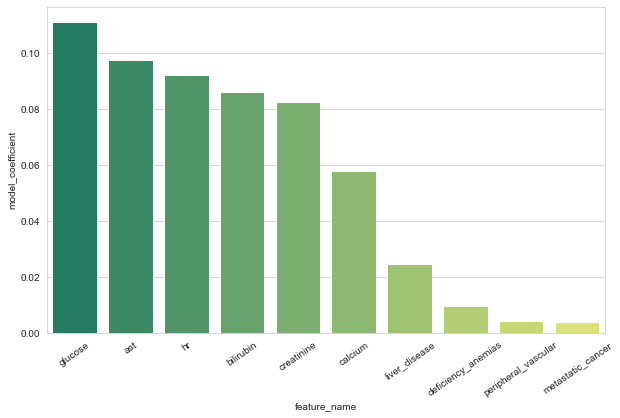

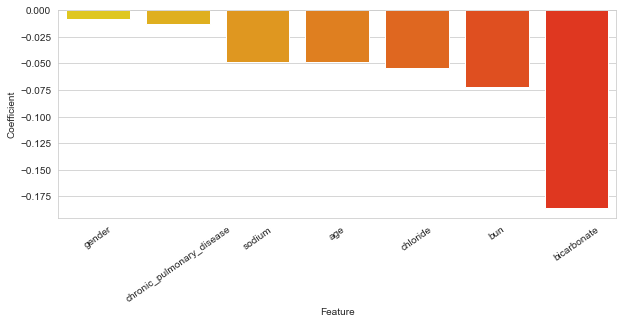

In [13]:
print("Importance of features for MIMIC after CV") 
    
# Get the models coefficients (and top 5 and bottom 5)
logReg_coeff_rf_mimic = pd.DataFrame({'feature_name': x_rf.columns.values, 'model_coefficient': importances})
logReg_coeff_rf_mimic = logReg_coeff_rf_mimic.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff_rf_mimic.head(sum(logReg_coeff_rf_mimic['model_coefficient']>0))
logReg_coeff_bottom = logReg_coeff_rf_mimic.tail(sum(logReg_coeff_rf_mimic['model_coefficient']<0))


# Plot top 5 coefficients
plt.figure(100).set_size_inches(10, 6)
fg3 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="summer")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure(101).set_size_inches(10,6)
fg4 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="autumn_r")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
# plt.savefig('figure_4.png')

In [14]:
print("Classification")
from sklearn import metrics
pred=bestRF.predict(x_rf)
classes_rf=np.where(np.logical_and(pred==1,y_rf.values==1),'TP',
         np.where(np.logical_and(pred==1,y_rf.values==0),'FP',
                  np.where(np.logical_and(pred==0,y_rf.values==0), 'TN',
                           np.where(np.logical_and(pred==0,y_rf.values==1),'FN','MAL'))))
import scipy
print(scipy.stats.itemfreq(classes_rf))


Classification
[['FN' '30']
 ['FP' '43']
 ['TN' '484']
 ['TP' '738']]


In [15]:
logReg_coeff_rf_mimic.to_csv('GeneratedFiles/ImportantVariables/coef_rf_mimic_2.csv', sep=';', header = False, index=False)


# ORTHOGONAL PLS

In [16]:
print("--------------------------")

print("Orthogonal PLS at MIMIC for feature selection")


categorical=mimic_pls[list(mimic_pls.columns[mimic_pls.dtypes==np.object])].drop(['lactate_label'],axis=1)
for col in categorical:
    mimic_pls[col] = np.where(mimic_pls[col]=='Yes',1,0)

mimic_pls['lactate_label'] = np.where(mimic_pls['lactate_label'] == 'high',1,0)

y_lr = mimic_pls['lactate_label']
x_lr= mimic_pls.drop(['lactate_label'],axis=1)


# x_lr=x_lr.drop('classes', axis=1)
y_lr = np.array(y_lr, dtype=int)

--------------------------
Orthogonal PLS at MIMIC for feature selection


In [17]:

from sklearn.model_selection import KFold
from pyopls import OPLS
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn import metrics

x_pls = x_lr
kf = KFold(n_splits=5)
accuracy_pls_componentes=list()
roc_pls_componentes=list()
coefs_componentes = list()
recall_componentes = list()
for train_index, test_index in kf.split(mimic_pls):
    X_train = x_pls.iloc[train_index]
    X_test = x_pls.iloc[test_index]
    y_train, y_test = y_lr[train_index], y_lr[test_index]
    opls = OPLS(3,scale=False)
    Z = opls.fit(X_train, y_train)
    Z_trans= Z.transform(X_train)
    pls2 = PLSRegression(1,scale=False)
    pls2.fit(Z_trans, y_train)
    Z_trans_test = Z.transform(X_test)
    predict=pls2.predict(Z_trans_test)
    predict_roc=np.where(predict>1,1,np.where(predict<0,0,predict))
    roc_pls_componentes.append(metrics.roc_auc_score(y_test,predict_roc))
    predict_auc=np.where(predict>=0.5,1,0)
    accuracy_pls_componentes.append(metrics.accuracy_score(y_test,predict_auc))
    recall_componentes.append(metrics.recall_score(y_test,predict_auc))
    coefs_componentes.append(pls2.coef_)

print(accuracy_pls_componentes)
print(roc_pls_componentes)

scores=pd.DataFrame(accuracy_pls_componentes)
scores.columns=['score']
scores = scores.sort_values('score',ascending=False)
print("Score for CV")
print(scores)


print('roc '+str(roc_pls_componentes[scores.iloc[0].name]))
print('recall '+str(recall_componentes[scores.iloc[0].name]))


[0.7722007722007722, 0.7606177606177607, 0.7644787644787645, 0.7722007722007722, 0.7953667953667953]
[0.8664274322169059, 0.840503144654088, 0.8473142016188374, 0.8465443425076453, 0.8706174464520761]
Score for CV
      score
4  0.795367
0  0.772201
3  0.772201
2  0.764479
1  0.760618
roc 0.8706174464520761
recall 0.8686131386861314


Importance of features for mimic after CV


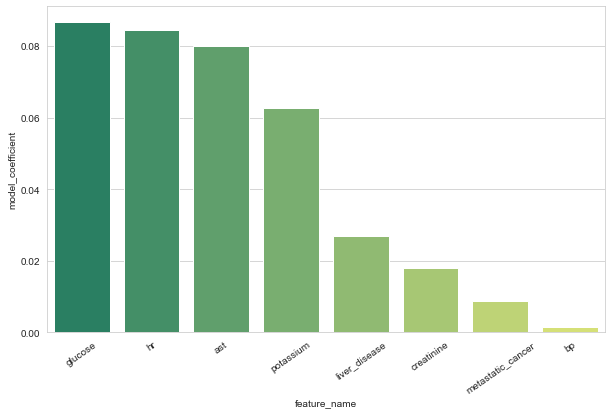

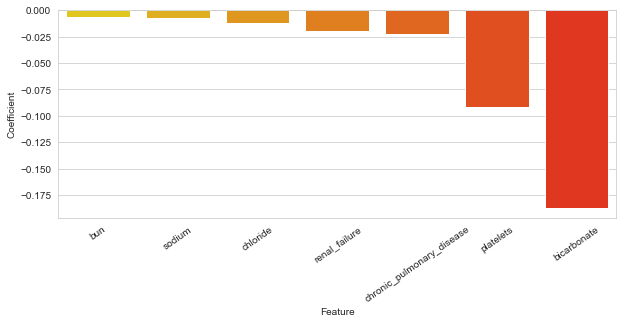

In [18]:
print("Importance of features for mimic after CV") 
feature_importances_ = coefs_componentes[scores.iloc[0].name]
# Get the models coefficients (and top 5 and bottom 5)
logReg_coeff_pls_mimic = pd.DataFrame({'feature_name': x_pls.columns.values, 'model_coefficient': feature_importances_.transpose().flatten()})
logReg_coeff_pls_mimic = logReg_coeff_pls_mimic.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff_pls_mimic.head(sum(logReg_coeff_pls_mimic['model_coefficient']>0))
logReg_coeff_bottom = logReg_coeff_pls_mimic.tail(sum(logReg_coeff_pls_mimic['model_coefficient']<0))


# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="summer")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
# Plot bottom 5 coefficients
plt.figure().set_size_inches(10,6)
fg4 = sb.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="autumn_r")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
# plt.savefig('figure_4.png')

In [19]:
logReg_coeff_pls_mimic.to_csv('GeneratedFiles/ImportantVariables/coef_pls_mimic_2.csv', sep=';', header = False, index=False)